In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline

In [2]:
results = pd.read_csv("input/international_football_results_from1872to2024/results.csv")

In [3]:
results["date"] = pd.to_datetime(results["date"])
results =  results.replace({'Germany DR': 'Germany', 'China': 'China PR'})

In [4]:
results = results[(results["date"] >= "2002-06-01")].reset_index(drop=True)

In [5]:
results.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20421 entries, 0 to 20420
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        20421 non-null  datetime64[ns]
 1   home_team   20421 non-null  object        
 2   away_team   20421 non-null  object        
 3   home_score  20421 non-null  int64         
 4   away_score  20421 non-null  int64         
 5   tournament  20421 non-null  object        
 6   city        20421 non-null  object        
 7   country     20421 non-null  object        
 8   neutral     20421 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 1.3+ MB


In [7]:
results.sort_values("date").head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,Sapporo,Japan,True
1,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,Niigata,Japan,True
2,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,Ulsan,South Korea,True
3,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,Kashima,Japan,True
4,2002-06-02,England,Sweden,1,1,FIFA World Cup,Saitama,Japan,True


In [8]:
rank = pd.read_csv("input/fifa_ranking/fifa_ranking-2023-07-20.csv")

In [9]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])

In [10]:
rank = rank[(rank["rank_date"] >= "2002-05-15")].reset_index(drop=True)

In [11]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

The merge is made in order to get a dataset FIFA games and its rankings.

In [12]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [13]:
df = results.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], 
                   left_on=["date", "home_team"], right_on=["rank_date", "country_full"])

In [14]:
df = df.drop(["rank_date", "country_full"], axis=1)

In [15]:
df = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], 
              left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away"))

In [16]:
df = df.drop(["rank_date", "country_full"], axis=1)

In [17]:
df[(df.home_team == "France") | (df.away_team == "France")].tail(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
16380,2022-11-26,France,Denmark,2,1,FIFA World Cup,Doha,Qatar,True,1759.78,1764.85,4.0,0.0,1666.57,1665.47,10.0,0.0
16396,2022-11-30,Tunisia,France,1,0,FIFA World Cup,Al Rayyan,Qatar,True,1507.54,1507.86,30.0,0.0,1759.78,1764.85,4.0,0.0
16407,2022-12-04,France,Poland,3,1,FIFA World Cup,Doha,Qatar,True,1759.78,1764.85,4.0,0.0,1548.59,1546.18,26.0,0.0
16417,2022-12-10,England,France,1,2,FIFA World Cup,Al Khor,Qatar,True,1728.47,1737.46,5.0,0.0,1759.78,1764.85,4.0,0.0
16420,2022-12-14,France,Morocco,2,0,FIFA World Cup,Al Khor,Qatar,True,1759.78,1764.85,4.0,0.0,1563.50,1558.35,22.0,-1.0
16425,2022-12-18,Argentina,France,3,3,FIFA World Cup,Lusail,Qatar,True,1773.88,1770.65,3.0,0.0,1759.78,1764.85,4.0,0.0
16508,2023-03-24,France,Netherlands,4,0,UEFA Euro qualification,Paris,France,False,1823.39,1759.78,3.0,-1.0,1740.92,1694.51,6.0,-2.0
16563,2023-03-27,Republic of Ireland,France,0,1,UEFA Euro qualification,Dublin,Republic of Ireland,False,1438.59,1440.19,48.0,-1.0,1823.39,1759.78,3.0,-1.0
16653,2023-06-16,Gibraltar,France,0,3,UEFA Euro qualification,Faro-Loulé,Portugal,True,854.72,858.04,201.0,1.0,1838.45,1823.39,2.0,-1.0
16707,2023-06-19,France,Greece,1,0,UEFA Euro qualification,Paris,France,False,1838.45,1823.39,2.0,-1.0,1433.01,1433.59,52.0,1.0


In [18]:
# Home win: 1, Away win: 0, Draw: 2
df["winner"] = "-"
df["result"] = "-"

def get_winner(df):
    if(int(df["home_score"]) == int(df["away_score"])):
        df['winner'] = 2
        df["result"] = "Draw"
    elif(int(df["home_score"]) > int(df["away_score"])):
        df["winner"] = 1
        df["result"] = "Home Win"
    else:
        df["winner"] = 0
        df["result"] = "Away Win"
    return df

In [19]:
df = df.apply(get_winner, axis='columns')
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,winner,result
0,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,Sapporo,Japan,True,695.00,697.00,11.0,-1.0,627.00,628.00,34.0,0.0,1,Home Win
1,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,Niigata,Japan,True,674.00,670.00,15.0,-4.0,672.00,670.00,17.0,-1.0,2,Draw
2,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,Ulsan,South Korea,True,652.00,660.00,24.0,3.0,657.00,660.00,20.0,0.0,0,Away Win
3,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,Kashima,Japan,True,784.00,786.00,3.0,0.0,644.00,640.00,27.0,-2.0,1,Home Win
4,2002-06-02,England,Sweden,1,1,FIFA World Cup,Saitama,Japan,True,694.00,698.00,12.0,1.0,665.00,671.00,19.0,2.0,2,Draw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16776,2023-07-09,Guatemala,Jamaica,0,1,Gold Cup,Cincinnati,United States,True,1166.60,1164.64,116.0,0.0,1367.83,1381.87,63.0,0.0,0,Away Win
16777,2023-07-09,United States,Canada,2,2,Gold Cup,Cincinnati,United States,False,1673.34,1653.77,11.0,-2.0,1454.12,1442.66,45.0,-2.0,2,Draw
16778,2023-07-12,United States,Panama,1,1,Gold Cup,San Diego,United States,False,1673.34,1653.77,11.0,-2.0,1399.23,1399.23,57.0,-1.0,2,Draw
16779,2023-07-12,Jamaica,Mexico,0,3,Gold Cup,Paradise,United States,True,1367.83,1381.87,63.0,0.0,1639.19,1631.87,14.0,-1.0,0,Away Win


In [20]:
df_home_away = df[df["neutral"] == False]
df_home_away

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,winner,result
11,2002-06-04,Japan,Belgium,2,2,FIFA World Cup,Saitama,Japan,False,634.00,632.00,32.0,-1.0,653.00,657.00,23.0,1.0,2,Draw
12,2002-06-04,South Korea,Poland,2,0,FIFA World Cup,Busan,South Korea,False,603.00,602.00,40.0,-1.0,615.00,620.00,38.0,0.0,1,Home Win
19,2002-06-07,Andorra,Armenia,0,2,Friendly,Sant Julià de Lòria,Andorra,False,286.00,272.00,141.0,-3.0,433.00,439.00,101.0,2.0,0,Away Win
25,2002-06-08,Malawi,Botswana,2,0,Friendly,Lilongwe,Malawi,False,353.00,357.00,122.0,1.0,303.00,303.00,139.0,1.0,1,Home Win
28,2002-06-09,Japan,Russia,1,0,FIFA World Cup,Yokohama,Japan,False,634.00,632.00,32.0,-1.0,644.00,650.00,28.0,4.0,1,Home Win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16765,2023-07-01,India,Lebanon,0,0,SAFF Cup,Bengaluru,India,False,1204.90,1200.66,100.0,-1.0,1201.74,1202.74,102.0,3.0,2,Draw
16768,2023-07-02,United States,Trinidad and Tobago,6,0,Gold Cup,Charlotte,United States,False,1673.34,1653.77,11.0,-2.0,1203.28,1197.61,101.0,-3.0,1,Home Win
16771,2023-07-04,India,Kuwait,1,1,SAFF Cup,Bengaluru,India,False,1204.90,1200.66,100.0,-1.0,1084.34,1071.92,141.0,-2.0,2,Draw
16777,2023-07-09,United States,Canada,2,2,Gold Cup,Cincinnati,United States,False,1673.34,1653.77,11.0,-2.0,1454.12,1442.66,45.0,-2.0,2,Draw


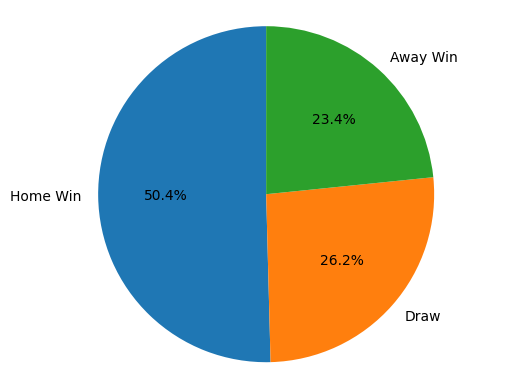

In [21]:
fig, ax = plt.subplots()
ax.pie(df_home_away["result"].value_counts(), labels = ["Home Win","Draw","Away Win"], startangle=90, autopct='%.1f%%', shadow=False)
ax.axis("equal")

plt.show()

In [22]:
df_host = df[(df["tournament"] == "FIFA World Cup") & (df["home_team"] == df["country"])]
df_host

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,winner,result
11,2002-06-04,Japan,Belgium,2,2,FIFA World Cup,Saitama,Japan,False,634.00,632.00,32.0,-1.0,653.00,657.00,23.0,1.0,2,Draw
12,2002-06-04,South Korea,Poland,2,0,FIFA World Cup,Busan,South Korea,False,603.00,602.00,40.0,-1.0,615.00,620.00,38.0,0.0,1,Home Win
28,2002-06-09,Japan,Russia,1,0,FIFA World Cup,Yokohama,Japan,False,634.00,632.00,32.0,-1.0,644.00,650.00,28.0,4.0,1,Home Win
31,2002-06-10,South Korea,United States,1,1,FIFA World Cup,Daegu,South Korea,False,603.00,602.00,40.0,-1.0,690.00,694.00,13.0,0.0,2,Draw
47,2002-06-14,Japan,Tunisia,2,0,FIFA World Cup,Osaka,Japan,False,634.00,632.00,32.0,-1.0,635.00,640.00,31.0,1.0,1,Home Win
48,2002-06-14,South Korea,Portugal,1,0,FIFA World Cup,Incheon,South Korea,False,603.00,602.00,40.0,-1.0,726.00,726.00,5.0,0.0,1,Home Win
56,2002-06-18,Japan,Turkey,0,1,FIFA World Cup,Rifu,Japan,False,634.00,632.00,32.0,-1.0,654.00,650.00,22.0,-3.0,0,Away Win
57,2002-06-18,South Korea,Italy,2,1,FIFA World Cup,Daejeon,South Korea,False,603.00,602.00,40.0,-1.0,717.00,722.00,6.0,0.0,1,Home Win
61,2002-06-22,South Korea,Spain,0,0,FIFA World Cup,Gwangju,South Korea,False,603.00,602.00,40.0,-1.0,713.00,715.00,8.0,0.0,2,Draw
63,2002-06-25,South Korea,Germany,0,1,FIFA World Cup,Seoul,South Korea,False,603.00,602.00,40.0,-1.0,695.00,697.00,11.0,-1.0,0,Away Win


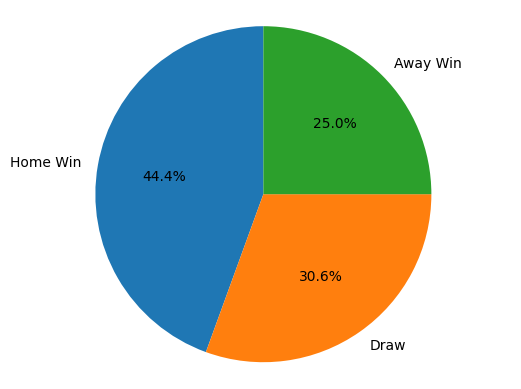

In [23]:
fig, ax = plt.subplots()
ax.pie(df_host["result"].value_counts(), labels = ["Home Win","Draw","Away Win"], startangle=90, autopct='%.1f%%', shadow=False)
ax.axis("equal")

plt.show()

In [24]:
df["rank_diff"] = (df["rank_home"] - df["rank_away"])
df["point_diff"] = df["total_points_home"] - df["total_points_away"]
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'winner', 'result', 'rank_diff', 'point_diff'],
      dtype='object')

In [25]:
df = df.drop(["tournament", "city", "country", "neutral", "previous_points_home", 
              "rank_change_home", "previous_points_away", "rank_change_away", "result"], axis=1)

In [26]:
df.tail()

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,winner,rank_diff,point_diff
16776,2023-07-09,Guatemala,Jamaica,0,1,1166.60,116.0,1367.83,63.0,0,53.0,-201.23
16777,2023-07-09,United States,Canada,2,2,1673.34,11.0,1454.12,45.0,2,-34.0,219.22
16778,2023-07-12,United States,Panama,1,1,1673.34,11.0,1399.23,57.0,2,-46.0,274.11
16779,2023-07-12,Jamaica,Mexico,0,3,1367.83,63.0,1639.19,14.0,0,49.0,-271.36
16780,2023-07-16,Mexico,Panama,1,0,1639.19,14.0,1399.23,57.0,1,-43.0,239.96


In [27]:
df.isna().sum()

date                 0
home_team            0
away_team            0
home_score           0
away_score           0
total_points_home    0
rank_home            0
total_points_away    0
rank_away            0
winner               0
rank_diff            0
point_diff           0
dtype: int64

In [28]:
def win_or_lose(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["winner"].apply(lambda x: win_or_lose(x))

In [29]:
df = df.drop(["winner"], axis=1)
df

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
0,2002-06-01,Germany,Saudi Arabia,8,0,695.00,11.0,627.00,34.0,-23.0,68.00,1
1,2002-06-01,Republic of Ireland,Cameroon,1,1,674.00,15.0,672.00,17.0,-2.0,2.00,1
2,2002-06-01,Uruguay,Denmark,1,2,652.00,24.0,657.00,20.0,4.0,-5.00,0
3,2002-06-02,Argentina,Nigeria,1,0,784.00,3.0,644.00,27.0,-24.0,140.00,1
4,2002-06-02,England,Sweden,1,1,694.00,12.0,665.00,19.0,-7.0,29.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16776,2023-07-09,Guatemala,Jamaica,0,1,1166.60,116.0,1367.83,63.0,53.0,-201.23,0
16777,2023-07-09,United States,Canada,2,2,1673.34,11.0,1454.12,45.0,-34.0,219.22,1
16778,2023-07-12,United States,Panama,1,1,1673.34,11.0,1399.23,57.0,-46.0,274.11,1
16779,2023-07-12,Jamaica,Mexico,0,3,1367.83,63.0,1639.19,14.0,49.0,-271.36,0


In [30]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'total_points_home', 'rank_home', 'total_points_away', 'rank_away',
       'rank_diff', 'point_diff', 'target'],
      dtype='object')

In [31]:
X = df[["total_points_home", "total_points_away", "rank_home", "rank_away"]]
y = df["target"]

model = LinearRegression()
model.fit(X, y)

X = sm.add_constant(X)
model_sm = sm.OLS(y, X).fit()
p_values = model_sm.pvalues

print("P-values:", p_values)

alpha = 0.05 # Significance level
for i, feature in enumerate(X.columns[1:]): # Exclude the intercept
    if p_values[i+1] < alpha:
        print(f"There is a significant relationship between {feature} and match outcomes.")
    else:
        print(f"There is no significant relationship between {feature} and match outcomes.")

P-values: const                 0.000000e+00
total_points_home     6.402477e-06
total_points_away     7.775253e-10
rank_home            1.857593e-109
rank_away            1.160900e-103
dtype: float64
There is a significant relationship between total_points_home and match outcomes.
There is a significant relationship between total_points_away and match outcomes.
There is a significant relationship between rank_home and match outcomes.
There is a significant relationship between rank_away and match outcomes.


In [32]:
predictors = ["rank_diff", "point_diff"]
X, y = df.loc[:, predictors], df["target"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

baseline_pred = baseline_model.predict(X_test)

accuracy = accuracy_score(y_test, baseline_pred)
print("Baseline Model Accuracy:", round(accuracy, 5))
f1 = f1_score(y_test, baseline_pred)
print("Baseline Model F1-score:", round(f1, 5))

Baseline Model Accuracy: 0.64611
Baseline Model F1-score: 0.74809


In [35]:
refined_model = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
refined_model.fit(X_train, y_train)

refined_pred = refined_model.predict(X_test)


refined_accuracy = accuracy_score(y_test, refined_pred)
print("Refined Model Accuracy:", round(refined_accuracy, 5))
refined_f1 = f1_score(y_test, refined_pred)
print("Refined Model F1-score:", round(refined_f1, 5))

Refined Model Accuracy: 0.73935
Refined Model F1-score: 0.83368


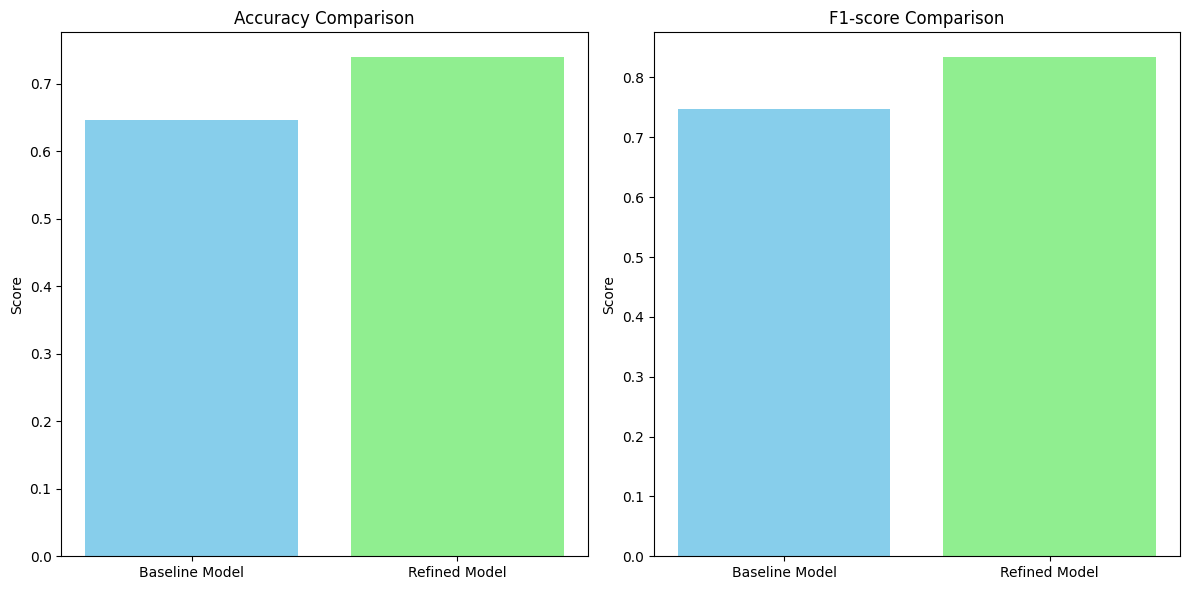

In [36]:
metrics = ["Baseline Model", "Refined Model"]

baseline_metrics = [accuracy, f1]
refined_metrics = [refined_accuracy, refined_f1]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(metrics, [accuracy, refined_accuracy], color=['skyblue', 'lightgreen'])
ax[0].set_title("Accuracy Comparison")
ax[0].set_ylabel("Score")

ax[1].bar(metrics, [f1, refined_f1], color=['skyblue', 'lightgreen'])
ax[1].set_title("F1-score Comparison")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()

### Using our model to make the prediction

In [37]:
usa_home = df[df["home_team"] == "United States"].sort_values(["date"], ascending=False)[:1]
usa_away = df[df["away_team"] == "United States"].sort_values(["date"], ascending=False)[:1]
argentina_home = df[df["home_team"] == "Argentina"].sort_values(["date"], ascending=False)[:1]
argentina_away = df[df["away_team"] == "Argentina"].sort_values(["date"], ascending=False)[:1]
france_home = df[df["home_team"] == "France"].sort_values(["date"], ascending=False)[:1]
france_away = df[df["away_team"] == "France"].sort_values(["date"], ascending=False)[:1]
japan_home = df[df["home_team"] == "Singapore"].sort_values(["date"], ascending=False)[:1]
japan_away = df[df["away_team"] == "Singapore"].sort_values(["date"], ascending=False)[:1]
qatar_home = df[df["home_team"] == "Qatar"].sort_values(["date"], ascending=False)[:1]
qatar_away = df[df["away_team"] == "Qatar"].sort_values(["date"], ascending=False)[:1]
norway_home = df[df["home_team"] == "Norway"].sort_values(["date"], ascending=False)[:1]
norway_away = df[df["away_team"] == "Norway"].sort_values(["date"], ascending=False)[:1]

In [38]:
game_list = pd.concat([usa_home, usa_away, argentina_home, argentina_away, france_home, france_away, 
                       japan_home, japan_away, qatar_home, qatar_away, norway_home, norway_away])
game_list

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16778,2023-07-12,United States,Panama,1,1,1673.34,11.0,1399.23,57.0,-46.0,274.11,1
16514,2023-03-24,Grenada,United States,1,7,963.72,173.0,1652.74,13.0,160.0,-689.02,0
16637,2023-06-15,Argentina,Australia,2,0,1840.93,1.0,1532.79,29.0,-28.0,308.14,1
16703,2023-06-19,Indonesia,Argentina,0,2,1046.14,149.0,1840.93,1.0,148.0,-794.79,0
16707,2023-06-19,France,Greece,1,0,1838.45,2.0,1433.01,52.0,-50.0,405.44,1
16653,2023-06-16,Gibraltar,France,0,3,854.72,201.0,1838.45,2.0,199.0,-983.73,0
16692,2023-06-18,Singapore,Solomon Islands,1,1,1014.04,158.0,1103.61,134.0,24.0,-89.57,1
16536,2023-03-26,Macau,Singapore,0,1,922.10,182.0,1006.10,160.0,22.0,-84.00,0
16762,2023-06-29,Qatar,Honduras,1,1,1393.52,58.0,1296.42,81.0,-23.0,97.10,1
16774,2023-07-08,Panama,Qatar,4,0,1399.23,57.0,1393.52,58.0,-1.0,5.71,1


### Game 1:  United States vs Qatar

In [39]:
game1_home = game_list[(game_list['home_team'] == 'United States') | (game_list['home_team'] == 'Qatar')]
game1_away = game_list[(game_list['away_team'] == 'United States') | (game_list['away_team'] == 'Qatar')]

In [40]:
game1_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16778,2023-07-12,United States,Panama,1,1,1673.34,11.0,1399.23,57.0,-46.0,274.11,1
16762,2023-06-29,Qatar,Honduras,1,1,1393.52,58.0,1296.42,81.0,-23.0,97.10,1


In [41]:
game1_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16514,2023-03-24,Grenada,United States,1,7,963.72,173.0,1652.74,13.0,160.0,-689.02,0
16774,2023-07-08,Panama,Qatar,4,0,1399.23,57.0,1393.52,58.0,-1.0,5.71,1


In [42]:
game1_home.index = [0, 1]
game1_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
0,2023-07-12,United States,Panama,1,1,1673.34,11.0,1399.23,57.0,-46.0,274.11,1
1,2023-06-29,Qatar,Honduras,1,1,1393.52,58.0,1296.42,81.0,-23.0,97.10,1


In [43]:
game1_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16514,2023-03-24,Grenada,United States,1,7,963.72,173.0,1652.74,13.0,160.0,-689.02,0
16774,2023-07-08,Panama,Qatar,4,0,1399.23,57.0,1393.52,58.0,-1.0,5.71,1


In [44]:
game1_away.index = [1, 0]
game1_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
1,2023-03-24,Grenada,United States,1,7,963.72,173.0,1652.74,13.0,160.0,-689.02,0
0,2023-07-08,Panama,Qatar,4,0,1399.23,57.0,1393.52,58.0,-1.0,5.71,1


In [45]:
game1_home = game1_home.drop(["date", "away_team", "away_score"], axis=1)
game1_away = game1_away.drop(["date", "home_team", "home_score"], axis=1)
game1_home = game1_home.drop(predictors, axis=1)
game1_away = game1_away.drop(predictors, axis=1)


In [46]:
game1 = pd.concat([game1_home, game1_away], axis=1)
game1

,home_team,home_score,total_points_home,rank_home,total_points_away,rank_away,target,away_team,away_score,total_points_home,rank_home,total_points_away,rank_away,target
0,United States,1,1673.34,11.0,1399.23,57.0,1,Qatar,0,1399.23,57.0,1393.52,58.0,1
1,Qatar,1,1393.52,58.0,1296.42,81.0,1,United States,7,963.72,173.0,1652.74,13.0,0


In [47]:
game1["rank_diff"] = (game1_home["rank_home"] - game1_away["rank_away"])
game1["point_diff"] = game1_home["total_points_home"] - game1_away["total_points_away"]
game1

,home_team,home_score,total_points_home,rank_home,total_points_away,rank_away,target,away_team,away_score,total_points_home,rank_home,total_points_away,rank_away,target,rank_diff,point_diff
0,United States,1,1673.34,11.0,1399.23,57.0,1,Qatar,0,1399.23,57.0,1393.52,58.0,1,-47.0,279.82
1,Qatar,1,1393.52,58.0,1296.42,81.0,1,United States,7,963.72,173.0,1652.74,13.0,0,45.0,-259.22


In [48]:
game1[['home_team', 'away_team']]

,home_team,away_team
0,United States,Qatar
1,Qatar,United States


In [49]:
def prediction(df, array):
    team_name = ""
    if array[0] == 1:
        team_name = df["home_team"][0]
        print(f"{team_name} Win!! (Home)")
    elif array[0] == 0:
        team_name = df["away_team"][0]
        print(f"{team_name} Win!! (Away)")
    if array[1] == 1:
        team_name = df["home_team"][1]
        print(f"{team_name} Win!! (Home)")
    elif array[1] == 0:
        team_name = df["away_team"][1]
        print(f"{team_name} Win!! (Away)")

In [50]:
game1_preds = refined_model.predict(game1[predictors])
prediction(game1, game1_preds)


United States Win!! (Home)
Qatar Win!! (Home)


### Game 2:  Argentina vs Norway

In [51]:
game2_home = game_list[(game_list['home_team'] == 'Argentina') | (game_list['home_team'] == 'Norway')]
game2_away = game_list[(game_list['away_team'] == 'Argentina') | (game_list['away_team'] == 'Norway')]

In [52]:
game2_home.index = [0, 1]
game2_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
0,2023-06-15,Argentina,Australia,2,0,1840.93,1.0,1532.79,29.0,-28.0,308.14,1
1,2023-06-20,Norway,Cyprus,3,1,1463.77,44.0,1179.45,111.0,-67.0,284.32,1


In [53]:
game2_away.index = [1, 0]
game2_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
1,2023-06-19,Indonesia,Argentina,0,2,1046.14,149.0,1840.93,1.0,148.0,-794.79,0
0,2023-03-28,Georgia,Norway,1,1,1305.98,78.0,1475.05,43.0,35.0,-169.07,1


In [54]:
game2_home = game2_home.drop(["date", "away_team", "away_score"], axis=1)
game2_away = game2_away.drop(["date", "home_team", "home_score"], axis=1)
game2_home = game2_home.drop(predictors, axis=1)
game2_away = game2_away.drop(predictors, axis=1)

game2 = pd.concat([game2_home, game2_away], axis=1)

In [55]:
game2["rank_diff"] = (game2_home["rank_home"] - game2_away["rank_away"])
game2["point_diff"] = game2_home["total_points_home"] - game2_away["total_points_away"]
game2

,home_team,home_score,total_points_home,rank_home,total_points_away,rank_away,target,away_team,away_score,total_points_home,rank_home,total_points_away,rank_away,target,rank_diff,point_diff
0,Argentina,2,1840.93,1.0,1532.79,29.0,1,Norway,1,1305.98,78.0,1475.05,43.0,1,-42.0,365.88
1,Norway,3,1463.77,44.0,1179.45,111.0,1,Argentina,2,1046.14,149.0,1840.93,1.0,0,43.0,-377.16


In [56]:
game2[['home_team', 'away_team']]

,home_team,away_team
0,Argentina,Norway
1,Norway,Argentina


In [57]:
game2_preds = refined_model.predict(game2[predictors])
prediction(game2, game2_preds)

Argentina Win!! (Home)
Argentina Win!! (Away)


### Game 3:  France vs Singapore

In [58]:
game3_home = game_list[(game_list['home_team'] == 'France') | (game_list['home_team'] == 'Singapore')]
game3_away = game_list[(game_list['away_team'] == 'France') | (game_list['away_team'] == 'Singapore')]

In [59]:
game3_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16707,2023-06-19,France,Greece,1,0,1838.45,2.0,1433.01,52.0,-50.0,405.44,1
16692,2023-06-18,Singapore,Solomon Islands,1,1,1014.04,158.0,1103.61,134.0,24.0,-89.57,1


In [60]:
game3_home.index = [0, 1]
game3_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
0,2023-06-19,France,Greece,1,0,1838.45,2.0,1433.01,52.0,-50.0,405.44,1
1,2023-06-18,Singapore,Solomon Islands,1,1,1014.04,158.0,1103.61,134.0,24.0,-89.57,1


In [61]:
game3_away.index = [1, 0]
game3_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
1,2023-06-16,Gibraltar,France,0,3,854.72,201.0,1838.45,2.0,199.0,-983.73,0
0,2023-03-26,Macau,Singapore,0,1,922.10,182.0,1006.10,160.0,22.0,-84.00,0


In [62]:
game3_home = game3_home.drop(["date", "away_team", "away_score"], axis=1)
game3_away = game3_away.drop(["date", "home_team", "home_score"], axis=1)
game3_home = game3_home.drop(predictors, axis=1)
game3_away = game3_away.drop(predictors, axis=1)

game3 = pd.concat([game3_home, game3_away], axis=1)

In [63]:
game3["rank_diff"] = (game3_home["rank_home"] - game3_away["rank_away"])
game3["point_diff"] = game3_home["total_points_home"] - game3_away["total_points_away"]
game3

,home_team,home_score,total_points_home,rank_home,total_points_away,rank_away,target,away_team,away_score,total_points_home,rank_home,total_points_away,rank_away,target,rank_diff,point_diff
0,France,1,1838.45,2.0,1433.01,52.0,1,Singapore,1,922.10,182.0,1006.10,160.0,0,-158.0,832.35
1,Singapore,1,1014.04,158.0,1103.61,134.0,1,France,3,854.72,201.0,1838.45,2.0,0,156.0,-824.41


In [64]:
game3[['home_team', 'away_team']]

,home_team,away_team
0,France,Singapore
1,Singapore,France


In [65]:
game3_preds = refined_model.predict(game3[predictors])
prediction(game3, game3_preds)

France Win!! (Home)
France Win!! (Away)


### Game 4:  Argentina vs France

In [66]:
game4_home = game_list[(game_list['home_team'] == 'Argentina') | (game_list['home_team'] == 'France')]
game4_away = game_list[(game_list['away_team'] == 'Argentina') | (game_list['away_team'] == 'France')]

In [67]:
game4_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16637,2023-06-15,Argentina,Australia,2,0,1840.93,1.0,1532.79,29.0,-28.0,308.14,1
16707,2023-06-19,France,Greece,1,0,1838.45,2.0,1433.01,52.0,-50.0,405.44,1


In [68]:
game4_home.index = [0, 1]
game4_home

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
0,2023-06-15,Argentina,Australia,2,0,1840.93,1.0,1532.79,29.0,-28.0,308.14,1
1,2023-06-19,France,Greece,1,0,1838.45,2.0,1433.01,52.0,-50.0,405.44,1


In [69]:
game4_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
16703,2023-06-19,Indonesia,Argentina,0,2,1046.14,149.0,1840.93,1.0,148.0,-794.79,0
16653,2023-06-16,Gibraltar,France,0,3,854.72,201.0,1838.45,2.0,199.0,-983.73,0


In [70]:
game4_away.index = [1, 0]
game4_away

,date,home_team,away_team,home_score,away_score,total_points_home,rank_home,total_points_away,rank_away,rank_diff,point_diff,target
1,2023-06-19,Indonesia,Argentina,0,2,1046.14,149.0,1840.93,1.0,148.0,-794.79,0
0,2023-06-16,Gibraltar,France,0,3,854.72,201.0,1838.45,2.0,199.0,-983.73,0


In [71]:
game4_home = game4_home.drop(["date", "away_team", "away_score"], axis=1)
game4_away = game4_away.drop(["date", "home_team", "home_score"], axis=1)
game4_home = game4_home.drop(predictors, axis=1)
game4_away = game4_away.drop(predictors, axis=1)

game4 = pd.concat([game4_home, game4_away], axis=1)

In [72]:
game4["rank_diff"] = (game4_home["rank_home"] - game4_away["rank_away"])
game4["point_diff"] = game4_home["total_points_home"] - game4_away["total_points_away"]
game4

,home_team,home_score,total_points_home,rank_home,total_points_away,rank_away,target,away_team,away_score,total_points_home,rank_home,total_points_away,rank_away,target,rank_diff,point_diff
0,Argentina,2,1840.93,1.0,1532.79,29.0,1,France,3,854.72,201.0,1838.45,2.0,0,-1.0,2.48
1,France,1,1838.45,2.0,1433.01,52.0,1,Argentina,2,1046.14,149.0,1840.93,1.0,0,1.0,-2.48


In [73]:
game4[['home_team', 'away_team']]

,home_team,away_team
0,Argentina,France
1,France,Argentina


In [74]:
game4_preds = refined_model.predict(game4[predictors])
prediction(game4, game4_preds)

Argentina Win!! (Home)
France Win!! (Home)
